In [1]:
import wisps
import numpy as np
import matplotlib.pyplot as plt
import wisps.simulations as wispsim
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import Normalize
import astropy.units as u 
import wisps.simulations.effective_numbers as eff
import seaborn as sns
import matplotlib
import itertools
#plt.style.use('dark_background')


%matplotlib inline

Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database












In [2]:
sgrid=wispsim.SPGRID
pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf110.pkl')
corr_pols=wisps.POLYNOMIAL_RELATIONS['mag_limit_corrections'] 
klf=pd.read_csv('/users/caganze/research/wisps/data/kirkpatricklf.txt', delimiter=',')
klf['bin_center']=np.mean(np.array([klf.t0.values, klf.tf.values]), axis=0)
klf=klf.replace(0.0,np.nan)

cands=pd.read_pickle(wisps.LIBRARIES+'/real_ucds.pkl')
cands=cands[(cands.spt >=17) & (cands.snr1>=3)].reset_index(drop=True)
tab=wisps.Annotator.reformat_table(cands)
pnt_names=[x.name for x in pnts]

In [3]:
#cmap= sns.color_palette("coolwarm", 8, as_cmap=True)
cmap=matplotlib.cm.get_cmap('coolwarm')
cnorm=Normalize(wispsim.HS[0]/100, (wispsim.HS[-1])/100)

In [4]:
kirkpatrick2020LF={'bin_center':np.flip(np.array([2025, 1875, 1725, 1575, 1425, 1275, 1125 , 975, 825, 675, 525])), 
                   'values':np.flip(np.array([0.72, 0.50,0.78, 0.81,0.94, 1.95, 1.11, 1.72, 1.99, 2.80, 4.24])), 
                   'unc':np.flip(([0.18, 0.17, 0.20,0.20, 0.22, 0.3, 0.25, 0.3, 0.32, 0.37, 0.70]))}


In [5]:
def bin_by_spt_bin(sp_types, number, ltonly=False):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 40]]
    if ltonly:
        ranges=[[17, 20], [20, 30], [30, 41]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

def get_all_numbers():
    #Distribute the parameter sets evenly across the cores
    func=lambda x, y:  get_simulated_number_model(y, x)

    paramlist=[(i, j)  for i, j in itertools.product(['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020'], wispsim.HS)]
    res  = [func(x, y) for x,y in tqdm(paramlist)]
    
    nbrs = {}
    for k in ['saumon2008', 'marley2019', 'phillips2020', 'baraffe2003']:
        ds0={}
        for j in res:
            if k in j.keys():
                key=[x for x in j[k].keys()][0]
                ds0.update({key: [(j[k][key])[yi] for yi in wispsim.SPGRID]})
        #print (ds0)
        nbrs[k]=np.array([ds0[k] for k in wispsim.HS])

    return nbrs
    


def get_pointing(grism_id):
    if grism_id.startswith('par'):
        pntname=grism_id.lower().split('-')[0]
    else:
        pntname=grism_id.lower().split('-g141')[0]
    loc=pnt_names.index(pntname)
    return np.array(pnts)[loc]


def iswithin_mag_limits(mags, pnt, spt):
    #mgs is a dictionary
    flags=[]
    for k in pnt.mag_limits.keys():
        if k =='F110' and pnt.survey =='hst3d':
            flags.append(True)
        else:
            flags.append(mags[k] <= pnt.mag_limits[k]+ (corr_pols[k+'W'][0])(spt))
    return np.logical_or.reduce(flags)

def scale_lf_teff(teffs):
    binedges= np.append(kirkpatrick2020LF['bin_center']-75, kirkpatrick2020LF['bin_center'][-1]-75)
    bools=np.logical_and(teffs <= binedges[-1], teffs >= binedges[0])
    preds=np.histogram(teffs, bins=binedges, normed=False)[0]
    
    obs=np.array(kirkpatrick2020LF['values'])
    unc=np.array(kirkpatrick2020LF['unc'])
    
    obs_monte_carlo= np.random.normal(obs, unc, (10000, len(obs)))
    pred_monte= np.ones_like(obs_monte_carlo)*(preds)
    unc_monte=  np.ones_like(obs_monte_carlo)*(unc)
    
    
    
    #unc_monte= 
    scale=(np.nansum((obs_monte_carlo*pred_monte)/(unc_monte**2), axis=1)\
           /np.nansum(((pred_monte**2)/(unc_monte**2)), axis=1))*(10**-3)
    
    
    
    #fig, ax=plt.subplots()
    #ax.step(kirkpatrick2020LF['bin_centertw'], preds*scale*(10**-3), where='mid')
    #x.errorbar(kirkpatrick2020LF['bin_center'], np.array(kirkpatrick2020LF['values'])*(10**-3),
    #         yerr= np.array(kirkpatrick2020LF['unc'])*(10**-3), fmt='o', color='#111111')
    return [np.nanmedian(scale), np.nanstd(scale), len(teffs)]
def get_simulated_number_model(hidx, model):
    #hidx is a scale height, model is evolutionary model
    cutdf=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut.h5', key=str(model)+str('h')+str(hidx)+'F110_corrected')
    scl_dict=pd.read_pickle(wisps.OUTPUT_FILES+'/lf_scales.pkl') 
    scale=scl_dict[model]
    #scale=scale_lf_teff(cutdf.teff)
    NSIM=dict(zip(wispsim.SPGRID,np.zeros((len(wispsim.SPGRID), 2))))
    cutdf['spt_r']=cutdf.spt.apply(np.round)
    for g in cutdf.groupby('spt_r'):
        sn= len(cutdf.teff[np.logical_and(cutdf.teff>=450, cutdf.teff<=1950)])
        n0=scale[-1]/scale[0]
        #print (n0)
        scln=np.array([scale[0]*n0/sn,\
                       (scale[1]*scale[-1])/(sn*scale[0])])
        #scln=np.array(scale)
        #assert scln[0] > scale[0]
        NSIM[g[0]]=np.nansum(g[1].sl)*scln
    del cutdf
    return {model: {hidx:NSIM}}


def plot(NUMBERS, VOLUMES, filename='/oberved_numbers.pdf'):
    # In[ ]:
    nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
    
    y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)
    yall=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)
    
    dy2=np.sqrt(y2)
    dyall=np.sqrt(yall)

    fig, ax=plt.subplots(figsize=(12, 12), ncols=2, nrows=2, sharey=False, sharex=False)
    
    for model, a in zip(['baraffe2003', 'saumon2008', 'marley2019', 'phillips2020'], np.concatenate(ax)):
        
        for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])[:,0]*VOLUMES[idx]
            nuncs=((NUMBERS[model])[idx])[:,1]*VOLUMES[idx]
            
            a.plot(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False), 
                          label='h={} pc'.format(h), color= cmap(cnorm(h/100)), 
                   linewidth=3, drawstyle="steps-mid")
            a.fill_between(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns+nuncs, ltonly=False),  
                           bin_by_spt_bin(wispsim.SPGRID,ns-nuncs, ltonly=False), alpha=0.5, 
                           color= cmap(cnorm(h/100)),  step="mid")
        
        a.set_yscale('log')
        a.errorbar(spgrid2,y2, yerr=dy2,fmt='o', color='#111111')
        a.errorbar(spgrid2,yall, yerr=dyall,color='#B10DC9', mfc='white', fmt='o')
        a.set_xlabel('SpT',fontsize=18)
        a.set_ylabel('N',fontsize=18)
        a.minorticks_on()
            


    ax[0][1].set_title('Model= SM08', fontsize=18)
    ax[0][0].set_title('Model= B03', fontsize=18)
    ax[1][0].set_title('Model= M19', fontsize=18)
    ax[1][1].set_title('Model= P20', fontsize=18)

    ax[0][-1].errorbar(spgrid2,y2, yerr=dy2,fmt='o', label='Mag Limited', color='#111111')
    ax[0][-1].errorbar(spgrid2,yall, yerr=dyall,color='#B10DC9', fmt='o', mfc='white', label='All Observations')
    
    ax[0][-1].legend(fontsize=14,  bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(wisps.OUTPUT_FIGURES+filename, bbox_inches='tight')

In [6]:
def plot_one(NUMBERS, VOLUMES, filename='/oberved_numbers_one_panel.pdf'):
    data_to_save={}
    # In[ ]:
    nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
    
    y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)
    yall=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)
    
    dy2=np.sqrt(y2)
    dyall=np.sqrt(yall)
     #add this to the dictionary
    data_to_save['nall']=nall
    data_to_save['nobs']=nobs
    data_to_save['yall']=yall
    data_to_save['y2']=y2

    fig, a=plt.subplots(figsize=(8, 6))
    
    #for model, a in zip(['baraffe2003', 'saumon2008', 'marley2019', 'phillips2020'], np.concatenate(ax)):
    model='baraffe2003'
    for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])[:,0]*VOLUMES[idx]
            nuncs=((NUMBERS[model])[idx])[:,1]*VOLUMES[idx]
            
            a.plot(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False), 
                          label='h={} pc'.format(h), color= cmap(cnorm(h/100)), 
                   linewidth=3, drawstyle="steps-mid")
            a.fill_between(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns+nuncs, ltonly=False),  
                           bin_by_spt_bin(wispsim.SPGRID,ns-nuncs, ltonly=False), alpha=0.5, 
                           color= cmap(cnorm(h/100)),  step="mid")
            data_to_save.update({h: bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False)})
        
    a.set_yscale('log')
    a.errorbar(spgrid2,y2, yerr=dy2,fmt='o', color='#111111')
    a.errorbar(spgrid2,yall, yerr=dyall,color='#B10DC9', mfc='white', fmt='o')
    a.set_xlabel('SpT',fontsize=18)
    a.set_ylabel('N',fontsize=18)
    a.minorticks_on()
            

    #a.set_title('Model= SM08', fontsize=18)
    a.set_title('Model= B03', fontsize=18)
    #a.set_title('Model= M19', fontsize=18)
    #a.set_title('Model= P20', fontsize=18)

    a.errorbar(spgrid2,y2, yerr=dy2,fmt='o', label='Mag Limited', color='#111111')
    a.errorbar(spgrid2,yall, yerr=dyall,color='#B10DC9', fmt='o', mfc='white', label='All Observations')
    
    a.legend(fontsize=14,  bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(wisps.OUTPUT_FIGURES+filename, bbox_inches='tight',  facecolor='white', transparent=False)
    
    import pickle
    with open('/users/caganze/results.pkl', 'wb') as file:
        pickle.dump(data_to_save,file)

In [7]:
#d=pd.read_pickle(wisps.OUTPUT_FILES+'/distance_samples{}'.format(h))

In [8]:
#np.shape(d[17])

In [9]:
tab['pnt']=tab['grism_id'].apply(get_pointing)
tab['spt_val']=np.vstack(tab.spt.values)[:,0]
obsmgs=tab[['F140W', 'F110W', 'F160W']].rename(columns={"F110W": "F110", 
                                                                    "F140W": "F140",
                                                                    "F160W": "F160"}).to_dict('records')

flags=[iswithin_mag_limits(x, y, z) for x, y, z in zip(obsmgs, tab.pnt.values,tab.spt.values )]

#let's see what happens if we include all objects
#flags=np.ones(len(flags)).astype(bool)
cdf_to_use=tab[flags]

nobs=wisps.custom_histogram(cdf_to_use.spt_val.apply(wisps.make_spt_number), sgrid, 1)

spgrid2=['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']
spgrid3=['Late M', 'L', 'T']

In [10]:
for k in ['F140', 'F110', 'F160']:
    tab['lim_{}'.format(k)]=tab.pnt.apply(lambda x: x.mag_limits[k])
    tab['detected_{}'.format(k)]= tab[k+'W'] < tab['lim_{}'.format(k)]

In [11]:
subtab=(tab[tab.spt.between(30, 35)]).reset_index(drop=True)

In [12]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print( subtab[['F140W', 'F160W', 'lim_F140', 'lim_F160', 'detected_F140', 'detected_F160', 'grism_id',
#                  'spt']])

In [13]:
#NUMBERS=pd.read_pickle(wisps.OUTPUT_FILES+'/numbers_simulated.pkl')
NUMBERS=get_all_numbers()

100%|██████████| 44/44 [01:58<00:00,  2.70s/it]


In [14]:
#plt.hist(np.log10(NUMBERS['baraffe2003'][0][:,1]))

In [15]:
volumes=[]
for pnt in pnts:
    vs=[]
    for h in wispsim.HS:
        vsx=[]
        for g in wispsim.SPGRID:
            vsx.append((pnt.volumes[h])[g])
        vs.append(vsx)
    volumes.append(vs)
volumes=np.array(volumes)

VOLUMES=(np.nansum(volumes, axis=0))*4.1*(u.arcmin**2).to(u.radian**2)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


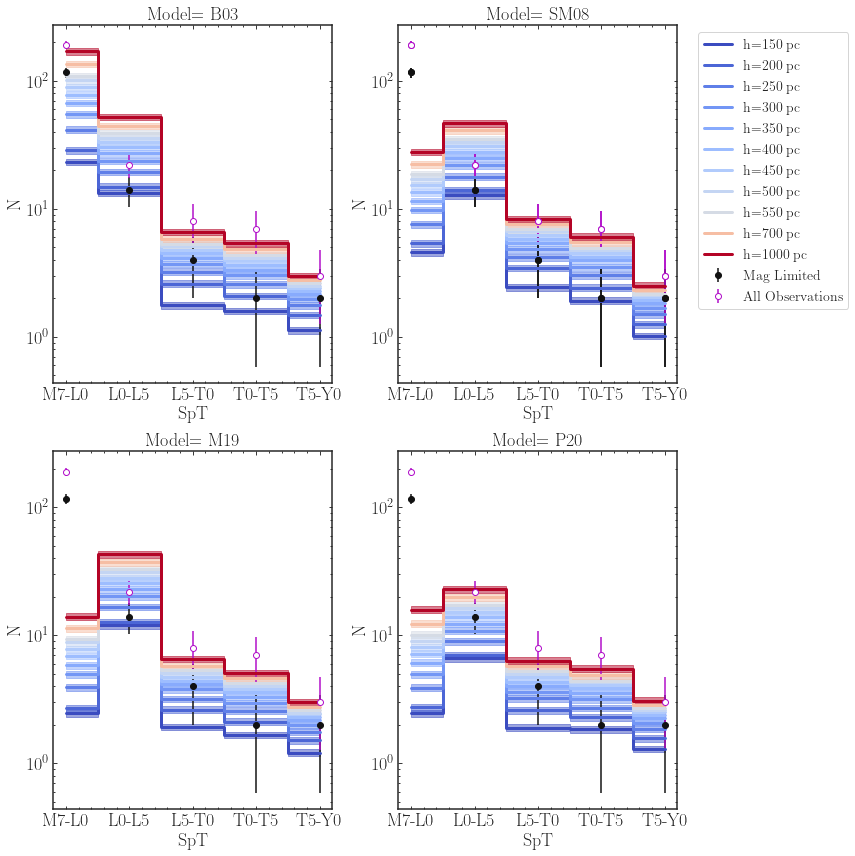

In [16]:
 plot(NUMBERS, VOLUMES, filename='/obs_numbers.pdf')

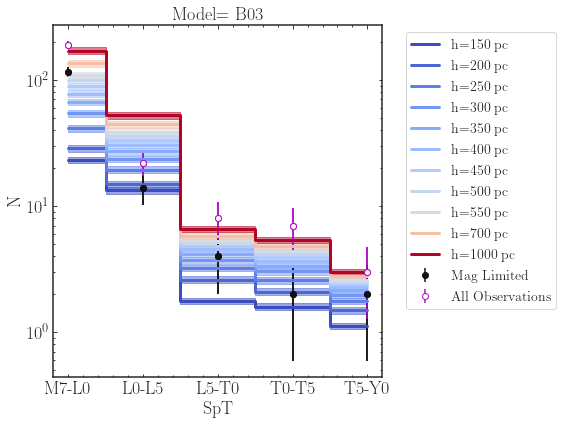

In [17]:
plot_one(NUMBERS, VOLUMES)

In [18]:
nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)

In [19]:
#cands[cands.spt.between(30, 35)].F140W,cands[cands.spt.between(30, 35)].F160W, 

In [20]:
#bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)

In [21]:
#just for L dwarfs and T dwarfs
y3=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)
y4=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=True)
y5= np.nansum(y4)
print ('all ----- {}'.format(y3))
print ('used ----- {}'.format(y2))
print ('MLT ----{}'.format(y4))
print ('All ----{}'.format(y5))


all ----- [190, 22, 8, 7, 3]
used ----- [116, 14, 4, 2, 2]
MLT ----[116, 18, 4]
All ----138


In [22]:
#PRINT THE BEST FIT NUMBER 
#best_fit={}
numbers_fit={} #predictions for all
numbers_fit_lt={} #predictions for M, L, T
#numbers_fit_total={} #predictions for total number counts
for model in ['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020']:
        model_number_lt={}
        model_number={}
        for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])[:,0]*VOLUMES[idx]
            nuncs=((NUMBERS[model])[idx])[:,1]*VOLUMES[idx]
            
            binned=np.array(bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False))
            binned_lt= np.array(bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=True))
            #binned_unc=np.array(bin_by_spt_bin(wispsim.SPGRID,nuncs, ltonly=False))
            #add L and 
            #compute chi-squared
            #print (ns)
            #chisq= abs((y2-binned)**2/(y2))
            #model_fit.update({h: chisq})
            #binned_total=np.append(binned, binned_lt)
            #binned_total=np.append(binned, binned_lt)
            model_number.update({h: binned})
            model_number_lt.update({h: binned_lt})
        # best_fit.update({model: model_fit})
        numbers_fit.update({model: model_number})
        numbers_fit_lt.update({model:  model_number_lt})

In [23]:
#chisq_dicts=pd.DataFrame.from_records(best_fit)
pred_number_dicts=pd.DataFrame.from_records(numbers_fit)
pred_number_lt_dicts=pd.DataFrame.from_records(numbers_fit_lt)

In [24]:
from scipy.interpolate import interp1d

In [25]:
def get_poisson_predictions(spt_grid, obstns, predns):
    res={}
    for c in  predns.columns:
        min_vals={}
        dist={}
        #for idx,s  in enumerate(np.append(spgrid2, ['L dwarfs', 'T dwarfs'])):
        for idx,s  in enumerate(spt_grid):
            #compare between subtypes
            #predicted
            predvals=(np.vstack(predns[c].values))[:,idx]
            #observed
            nreal=  obstns[idx]
            #make an interpolation function
            interpf = interp1d(predvals, wispsim.HS)
            #using a 2nd degree polynomial 

            #draw a bunch of random values based on a poisson distribution
            npoisson=np.random.poisson(nreal, 100000).astype(float)
            #stay within the range of possible values to avoid interpolation error
            #i.e take this as a prior
            #dflag=npoisson>=vals.min()
            #uflag= npoisson <=vals.max()
            #npoisson[dflag]= vals.min()
            #npoisson[uflag]= vals.max()
            npoisson=npoisson[np.logical_and(npoisson>=predvals.min(), npoisson <=predvals.max())]
            #predict scale heights
            predhs=interpf(npoisson)
            #use a weighted mean and std 
            #mean, unc= (np.nanmean(predhs), np.nanstd(predhs))

            #print (' scale height for model {} and spt {} is {} +/- {} '.format(c, s, np.round(mean), np.round(unc, 4)))
            dist.update({s:predhs})
        #min_chi_ssqrs.update({c:min_vals})
        res.update({c: dist})
    return  res

In [26]:
#number_dicts

In [27]:
#min_chi_ssqrs={}


In [28]:
def compute_vdispersion(hs):
    return np.sqrt((np.array(hs)*68)/435*20)
def compute_age(sigmas):
    beta, tau1, sigma10= 0.385, 0.261, 57.15747
    return ((sigmas/sigma10)**(1/beta))*(10+tau1)-tau1
scale_height_dist=get_poisson_predictions(spgrid2, y2,pred_number_dicts)
scale_height_dist_df=pd.DataFrame(scale_height_dist)
vel_df=scale_height_dist_df.applymap(compute_vdispersion)
age_distdf=vals=vel_df.applymap(compute_age)

In [29]:
scalh_tables=scale_height_dist_df.applymap(lambda x: (np.nanmedian(x), np.nanstd(x)))
vel_tables=vel_df.applymap(lambda x: (np.nanmedian(x), np.nanstd(x)))
age_tables=age_distdf.applymap(lambda x: (np.nanmedian(x), np.nanstd(x)))

In [30]:
scalh_tables[['baraffe2003', 'saumon2008', 'marley2019', 'phillips2020']]

,baraffe2003,saumon2008,marley2019,phillips2020
M7-L0,"(589.3659115300958, 62.66770766871768)","(nan, nan)","(nan, nan)","(nan, nan)"
L0-L5,"(212.00551856642923, 33.08166654409101)","(226.29502684660523, 41.13077293520512)","(228.73403782744447, 48.12808150819764)","(403.7085080735485, 145.20434766173707)"
L5-T0,"(332.31419772849426, 189.05332962117166)","(237.1684507835403, 160.596804883354)","(328.54491916529446, 202.92816329180764)","(344.71463909413455, 207.4638654239263)"
T0-T5,"(297.1949880688928, 159.21501226544498)","(248.5044835958861, 150.03750924358243)","(304.6822560503771, 192.79937201532923)","(281.5174971301301, 152.83198020173734)"
T5-Y0,"(305.57762512594536, 0.0)","(428.8454963404471, 1.1368683772161603e-13)","(302.7707942857672, 341.11291388009465)","(281.3580820236116, 297.0002427278547)"


In [31]:
import numpy as np
np.exp(-1/588)/np.exp(-1/290)

1.0017491235250744

In [32]:
vel_tables[['baraffe2003', 'saumon2008', 'marley2019', 'phillips2020']]

,baraffe2003,saumon2008,marley2019,phillips2020
M7-L0,"(42.92569467852935, 2.2725120583634455)","(nan, nan)","(nan, nan)","(nan, nan)"
L0-L5,"(25.745326782742833, 1.955873866513523)","(26.598817556960437, 2.4249721442256305)","(26.741774605843034, 2.788809098530233)","(35.52701969895188, 5.990955818681485)"
L5-T0,"(32.23289206430778, 8.281663033763694)","(27.230353798049165, 7.092469709617406)","(32.04956972705244, 8.795144137837264)","(32.82877589589721, 8.936890423466192)"
T0-T5,"(30.48214792314499, 7.056475282113816)","(27.873527905684583, 6.862220863539852)","(30.863729716603757, 8.108532757140072)","(29.667265760332548, 7.117881244722725)"
T5-Y0,"(30.909046035595175, 3.552713678800501e-15)","(36.616367015123515, 7.105427357601002e-15)","(30.76676368505556, 12.309164996883979)","(29.658864719365713, 11.275088724164403)"


In [33]:
age_tables[['baraffe2003', 'saumon2008', 'marley2019', 'phillips2020']]

,baraffe2003,saumon2008,marley2019,phillips2020
M7-L0,"(4.6163953587209825, 0.6766727687761518)","(nan, nan)","(nan, nan)","(nan, nan)"
L0-L5,"(1.0317526359338158, 0.26730605089870446)","(1.1460348024879234, 0.33354088922542713)","(1.1657612841450327, 0.3955070772047593)","(2.7229333299289262, 1.4723466461440187)"
L5-T0,"(2.0565236400293814, 1.8641261018370714)","(1.2344601634459242, 1.5821765436679258)","(2.0224432545396764, 2.0191621283417067)","(2.169455027415803, 2.073443310358432)"
T0-T5,"(1.7435990939413828, 1.5611486165173736)","(1.3279455687965465, 1.4655990745317646)","(1.8094315758050041, 1.965619013204517)","(1.6073626682521995, 1.4588153187175952)"
T5-Y0,"(1.8173368242390278, 0.0)","(2.9664378171006844, 4.440892098500626e-16)","(1.7925784330624146, 3.7355877336324417)","(1.6059887597821514, 3.1525562592184064)"


In [51]:
def propagate_uncertainties(row):
    vals=np.vstack(row.values)[:, 0]
    uncs=np.vstack(row.values)[:,1]
    
    return np.round(np.nanmedian(vals), 1), \
np.round(np.sqrt(np.nansum(uncs**2)+ np.nanstd(vals)**2), 1)

In [63]:
age_distdf.apply(lambda x: np.concatenate(x), axis=1).apply(lambda x: (np.nanmedian(x), np.nanstd(x)))

M7-L0    (4.6163953587209825, 0.6766727687761518)
L0-L5     (1.300839459723293, 1.2555741571271368)
L5-T0    (1.9130484542689126, 1.9127923737664656)
T0-T5    (1.3279455687965465, 1.6385660820114147)
T5-Y0    (1.8173368242390278, 2.9502125118088833)
dtype: object

In [64]:
vel_df.apply(lambda x: np.concatenate(x), axis=1).apply(lambda x: (np.nanmedian(x), np.nanstd(x)))

M7-L0    (42.92569467852935, 2.2725120583634455)
L0-L5     (27.68949134808109, 6.042587431814472)
L5-T0    (31.449490697685334, 8.379995014359457)
T0-T5    (27.873527905684583, 7.385131359051568)
T5-Y0    (30.909046035595175, 9.964617844679987)
dtype: object

In [62]:
scale_height_dist_df.apply(lambda x: np.concatenate(x), axis=1).apply(lambda x: (np.nanmedian(x), np.nanstd(x)))

M7-L0      (589.3659115300958, 62.66770766871768)
L0-L5     (245.2337867906059, 131.25282206604297)
L5-T0    (316.35709730702314, 192.69336354995926)
T0-T5     (248.5044835958861, 166.06841367231212)
T5-Y0    (305.57762512594536, 271.75500348914113)
dtype: object

In [50]:
8/28

0.2857142857142857

In [38]:
#upper and lo limits on ages 
up_lims_table=pd.DataFrame(columns= age_tables.columns,
                           index=age_tables.index).fillna(0)
#up_lims_table.saumon2008['T0-T5']=1
#up_lims_table.saumon2008['T0-T5']=1

#lo limts
lo_lims_table=pd.DataFrame(columns= age_tables.columns,
                           index=age_tables.index).fillna(0)
lo_lims_table.baraffe2003['T5-Y0']=1
#lo_lims_table.baraffe2003['L5-T0']=1
#lo_lims_table.phillips2020['T5-Y0']=1
lo_lims_table.saumon2008['T5-Y0']=1
lo_lims_table.marley2019['T5-Y0']=1


In [39]:
def get_simpler_class(x):
    if x.startswith('M'):
        return 'Late M'
    if x.startswith('L'):
        return 'L'
    if x.startswith('T'):
        return 'T'

In [40]:
#plot age with scale heights
age_dictionaries={}
for model in ['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020']:
    dfs=[]
    for hidx in wispsim.HS:
        dfs.append(pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut.h5',
                               key=str(model)+str('h')+str(hidx)+'F110_corrected'))
        
    df=pd.concat(dfs)
    print (len(df))
    cutdf_lblded=wisps.Annotator.group_by_spt(df, spt_label='spt', assign_number=False).rename(columns={'spt_range': 'subtype'})
    cutdf_lblded['spectclass']=  cutdf_lblded.subtype.apply(get_simpler_class)
    final_df=cutdf_lblded[~((cutdf_lblded.spectclass=='') | (cutdf_lblded.subtype=='')|   (cutdf_lblded.subtype=='trash'))]
    age_dictionaries[model]=final_df

1475962
1594004
1440150
1379405


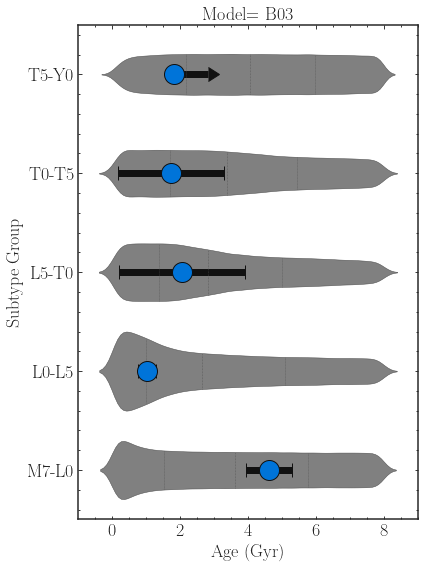

In [41]:

#fig, ax=plt.subplots(figsize=(12, 12), ncols=2, nrows=2, sharex=False, sharey=False)
fig, a= plt.subplots(figsize=(6, 8))
#for model, a in zip([ 'baraffe2003', 'saumon2008','marley2019', 'phillips2020'], np.concatenate(ax)):
model='baraffe2003'
dfn=age_dictionaries[model].replace('T5-T9', 'T5-Y0')
dfn['Survey']=dfn.pnt.apply(lambda x: x.survey)
dfn.Survey=dfn.Survey.replace('hst3d', '3d-hst'.upper())
dfn.Survey=dfn.Survey.replace('wisps', 'wisps'.upper())
age_emp=pd.DataFrame()
age_emp['subtype']=np.array(age_tables[model].index)
age_emp['age']=np.vstack(age_tables[model].values)[:,0]
age_emp['unc']=np.vstack(age_tables[model].values)[:,1]
age_emp.unc[age_emp.unc<0.01]=1
agfn= age_emp
#lower limits
lolims=lo_lims_table[model].values.astype(bool)
#upper limits
uplims =up_lims_table[model].values.astype(bool)
if model !='baraffe2003':
    dfn=dfn[dfn.subtype != 'M7-L0']
    agfn=agfn[agfn.subtype !='M7-L0']
    lolims=lo_lims_table[model].values.astype(bool)[1:]
    uplims =up_lims_table[model].values.astype(bool)[1:]

    sns.violinplot(x='age', y='subtype', data=dfn, ax=a,
               saturation=0.9, scale='area',
                   order=['L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0'], 
                   split=True, linewidth=0.5, inner="quartile", color='grey')
    a.set_ylim([-0.5, 3.5])
else:
    sns.violinplot(x='age', y='subtype', data=dfn, ax=a,
               saturation=0.9, scale='area', 
                   order=spgrid2, split=True, linewidth=0.5, inner="quartile", color='grey')
    a.set_ylim([-0.5, 4.5])


#sns.boxplot(y=dfn.age.values*dfn.slprob, x=dfn.spectclass, ax=a,
#            color='#FF851B')

#upper and low limit of the error
#print (lolims =
a.errorbar(  agfn.age, agfn.subtype, xerr=agfn.unc,  fmt='o',xlolims=lolims, ms=20, lw=7, 
           capsize=7, 
           mfc='#0074D9', mec='#111111', ecolor='#111111', xuplims=uplims)
#a.set_xlim()
a.set_ylabel('Subtype Group', fontsize=18)
a.set_xlabel('Age (Gyr)', fontsize=18)
a.set_xlim([-1, 9.])
a.minorticks_on()
a.set_title('Model= B03', fontsize=18)
#ax[0][0].set_title('Model= B03', fontsize=18)
#ax[0][1].set_title('Model= SM08', fontsize=18)
#ax[1][0].set_title('Model= M19', fontsize=18)
#ax[1][1].set_title('Model= P20', fontsize=18)

plt.tight_layout()


plt.savefig(wisps.OUTPUT_FIGURES+'/age_comparison_one.pdf', bbox_inches='tight',  facecolor='white', transparent=False)


In [42]:
scale_height_dist_df.apply(lambda x: np.concatenate(x.values), axis=0).apply(lambda x: \
                            (np.nanmedian(x), 
                            np.nanstd(x)))

baraffe2003      (305.57762512594536, 186.3293156767018)
marley2019       (297.9321332732552, 236.56359973089877)
phillips2020    (339.07760278931886, 210.70679834085576)
saumon2008       (239.37823241645822, 137.8130219912839)
dtype: object

In [43]:
age_tables

,baraffe2003,marley2019,phillips2020,saumon2008
M7-L0,"(4.6163953587209825, 0.6766727687761518)","(nan, nan)","(nan, nan)","(nan, nan)"
L0-L5,"(1.0317526359338158, 0.26730605089870446)","(1.1657612841450327, 0.3955070772047593)","(2.7229333299289262, 1.4723466461440187)","(1.1460348024879234, 0.33354088922542713)"
L5-T0,"(2.0565236400293814, 1.8641261018370714)","(2.0224432545396764, 2.0191621283417067)","(2.169455027415803, 2.073443310358432)","(1.2344601634459242, 1.5821765436679258)"
T0-T5,"(1.7435990939413828, 1.5611486165173736)","(1.8094315758050041, 1.965619013204517)","(1.6073626682521995, 1.4588153187175952)","(1.3279455687965465, 1.4655990745317646)"
T5-Y0,"(1.8173368242390278, 0.0)","(1.7925784330624146, 3.7355877336324417)","(1.6059887597821514, 3.1525562592184064)","(2.9664378171006844, 4.440892098500626e-16)"


In [44]:
import scipy.stats as stats

In [45]:
from pprint import pprint

In [46]:
for model in ['baraffe2003', 'saumon2008','marley2019', 'phillips2020']:
    for subtype in [ 'M7-L0','L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']:
        dfn=age_dictionaries[model].replace('T5-T9', 'T5-Y0')
        x=dfn[dfn.subtype ==subtype].age.values
        y=age_distdf[model][subtype]
        #fig, ax=plt.subplots()
        #h=plt.hist(x, density=True)
        #h=plt.hist(y, density=True)
        if len(y)==0:
            pass
        else:
            print (model, subtype)
            pprint(stats.ks_2samp(x, y, mode='asymp', alternative='two-sided'))
            #print (stats.anderson_ksamp(np.array([np.random.choice(x, 100),\
            #                                      np.random.choice(y, 100)])))
    print ('------------------------')

baraffe2003 M7-L0
KstestResult(statistic=0.4579654313049541, pvalue=0.0)
baraffe2003 L0-L5
KstestResult(statistic=0.6080059601883643, pvalue=0.0)
baraffe2003 L5-T0
KstestResult(statistic=0.29970153083886736, pvalue=0.0)
baraffe2003 T0-T5
KstestResult(statistic=0.5252830920094824, pvalue=0.0)
baraffe2003 T5-Y0
KstestResult(statistic=0.798257022889119, pvalue=0.0)
------------------------
saumon2008 L0-L5
KstestResult(statistic=0.6460643792171238, pvalue=0.0)
saumon2008 L5-T0
KstestResult(statistic=0.36063670306488, pvalue=0.0)
saumon2008 T0-T5
KstestResult(statistic=0.5626818997211424, pvalue=0.0)
saumon2008 T5-Y0
KstestResult(statistic=0.6552115422265374, pvalue=0.0)
------------------------
marley2019 L0-L5
KstestResult(statistic=0.5649294005617078, pvalue=0.0)
marley2019 L5-T0
KstestResult(statistic=0.2704515896156558, pvalue=0.0)
marley2019 T0-T5
KstestResult(statistic=0.5039472935743599, pvalue=0.0)
marley2019 T5-Y0
KstestResult(statistic=0.4018679089673004, pvalue=0.0)
-----------

In [47]:
stats.ks_2samp?

NameError: name 'number_dicts' is not defined

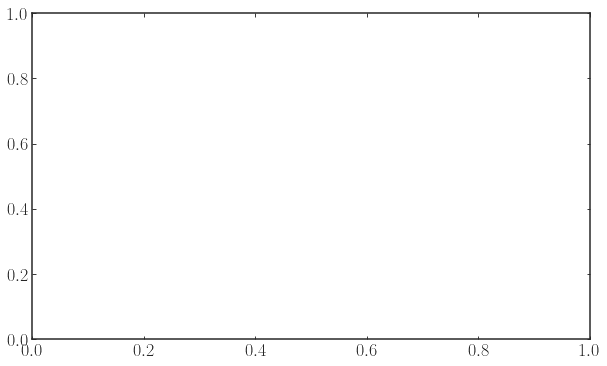

In [48]:
fig, ax=plt.subplots(figsize=(10, 6))
idx=0
for c in number_dicts.columns:
    
    vals=np.vstack([number_dicts[c][h] for h in wispsim.HS])[:,idx]

    interpf = interp1d(vals, wispsim.HS)
    npoisson=np.random.poisson(y3[idx], int(1e6)).astype(float)
    #assign up and down 
    dflag=npoisson>=vals.min()
    uflag= npoisson <=vals.max()
    npoisson[dflag]= vals.min()
    npoisson[uflag]= vals.max()
    predhs=interpf(npoisson)
    sortarray=np.argsort(npoisson)
    plt.plot(  (npoisson)[sortarray], predhs[sortarray],'o-', c='k', alpha=0.1)
    plt.plot(vals, wispsim.HS, 'o-', label=c)
plt.ylabel('h (expcted)', fontsize=18)
plt.xlabel('N', fontsize=18)
plt.xscale('log')
plt.axvline(y3[idx], c='k')
plt.legend()
plt.minorticks_on()
